<a href="https://colab.research.google.com/github/Pratch-yani/Face_Shape_Classification/blob/main/5_TRANSFER_LEARNING_VGGFACE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project:  Face Shape Classification - Part 5

This notebook explores transfer learning from a pre-trained Oxford VGGFace model.

As the VGGFace model was built on older versions of Keras (v2.2.4) and Tensorflow (v1.14.0), hence we will only use the weights from the model and apply to VGG-16 architecture.

More details on VGGFace can be found on [keras-vggface-project](https://github.com/rcmalli/keras-vggface) by [Refik Can Malli](https://www.linkedin.com/in/refik-can-malli-185b5aa4/).  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2
import random
import pickle
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix

%matplotlib inline


### Define Functions

In [ ]:
def plot_results(mod_history, metric, epochs):
      
      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [ ]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()



In [ ]:
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

### Load Data Files 

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data/"

X_train = np.asarray(pickle.load(open(path + "X_train_rgb.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_rgb.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_rgb.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_rgb.pickle","rb")))

In [ ]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (4000, 224, 224, 3)
y_train shape (4000, 5)
--------------------
X_test shape (1000, 224, 224, 3)
y_test shape (1000, 5)


## <span style = 'color:sienna'>Model TL: Transfer Learning from VGG16 with weights from VGG Face</span>  

In [ ]:
# Path for VGGFace weights

path_vggface = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/rcmalli_vggface_tf_notop_vgg16.h5'

In [ ]:
# Loading VGG16 as base model

base_model = VGG16(input_shape=(224, 224, 3),  # same as our input
                   include_top=False,  # exclude the last layer
                   weights=path_vggface)  # use VGGFace Weights

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
model_t1 = Sequential()

In [ ]:
# Compile and Fit the model

x = layers.Flatten()(base_model.output)

x = layers.Dense(64, activation='relu')(x)  # add 1 fully connected layer, try with 512 first 
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)  # add final layer

model_t1 = tf.keras.models.Model(base_model.input, x)



model_t1.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

model_t1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)

In [ ]:
datagen.fit(X_train)

In [ ]:
history_t1 = model_t1.fit(datagen.flow(X_train, y_train, batch_size=32), 
                          steps_per_epoch=len(X_train)/32, epochs=50, 
                          validation_data=(X_test, y_test))

Epoch 1/50
125/125 [==============================] - 42s 337ms/step - loss: 1.0247 - accuracy: 0.6037 - val_loss: 0.5754 - val_accuracy: 0.8350
Epoch 2/50
125/125 [==============================] - 41s 332ms/step - loss: 0.6480 - accuracy: 0.7703 - val_loss: 0.4566 - val_accuracy: 0.8430
Epoch 3/50
125/125 [==============================] - 41s 328ms/step - loss: 0.5259 - accuracy: 0.8152 - val_loss: 0.4047 - val_accuracy: 0.8580
Epoch 4/50
125/125 [==============================] - 41s 325ms/step - loss: 0.4530 - accuracy: 0.8385 - val_loss: 0.3379 - val_accuracy: 0.8800
Epoch 5/50
125/125 [==============================] - 40s 321ms/step - loss: 0.4011 - accuracy: 0.8633 - val_loss: 0.3205 - val_accuracy: 0.8990
Epoch 6/50
125/125 [==============================] - 41s 328ms/step - loss: 0.3633 - accuracy: 0.8725 - val_loss: 0.3168 - val_accuracy: 0.8950
Epoch 7/50
125/125 [==============================] - 41s 331ms/step - loss: 0.3489 - accuracy: 0.8767 - val_loss: 0.3382 - val_ac

Creating models from scratch already achieves 60% accuracy by 50 epochs, so the imagenet weights is less applicable to face shape

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/'
tf.keras.models.save_model(
    model_t1, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/assets


In [ ]:
filename = model_path + 'vgg16-face-1'   # change the filename for new iterations
model_t1.save(filename)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/vgg16-face-1/assets


In [ ]:
loaded_model = tf.keras.models.load_model(filename)
mod_t1_predict = np.argmax(model_t1.predict(X_test), axis=1) 
loaded_t1_predict = np.argmax(loaded_model.predict(X_test), axis=1)

# Check the difference

print(f'Difference in predictions: Saved model vs. original model is {np.sum(loaded_t1_predict - mod_t1_predict)}\nModel was correctly saved.')

Difference in predictions: Saved model vs. original model is 0
Model was correctly saved.


Normalized confusion matrix
[[0.95  0.015 0.01  0.01  0.015]
 [0.01  0.95  0.025 0.01  0.005]
 [0.055 0.015 0.835 0.065 0.03 ]
 [0.02  0.    0.055 0.915 0.01 ]
 [0.01  0.02  0.02  0.065 0.885]]


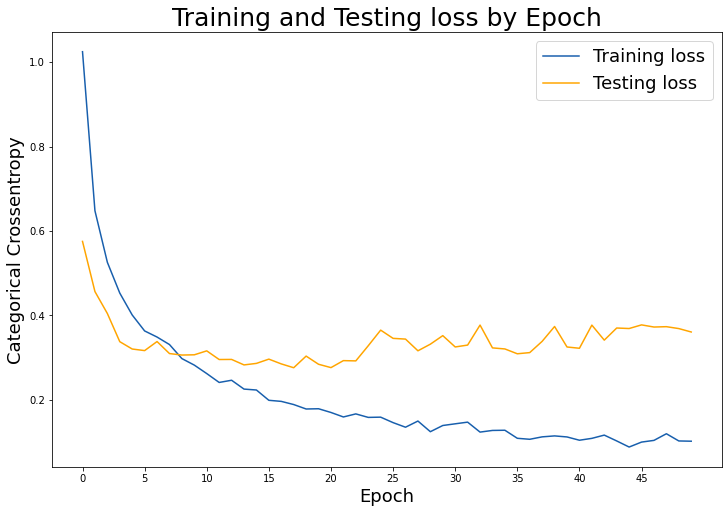

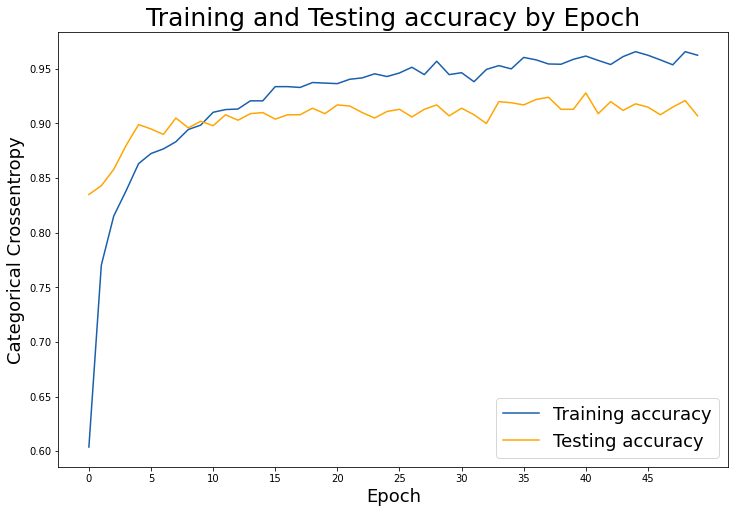

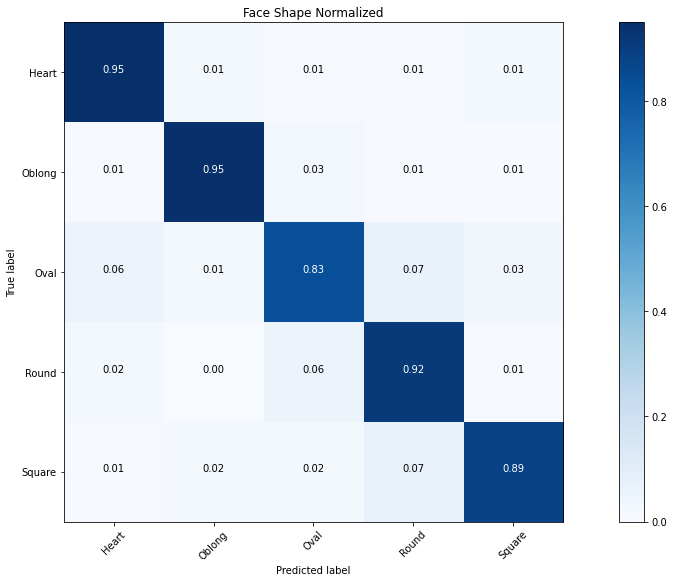

In [ ]:
plot_summary_results(model_t1, history_t1, 50)

Seems like the training accuracy is still on rising trend and the model has not fully converged.  Let's try to run a few more epochs.

In [ ]:
history_t2 = model_t1.fit(datagen.flow(X_train, y_train, batch_size=32), 
                          steps_per_epoch=len(X_train)/32, epochs=20, 
                          validation_data=(X_test, y_test))

Epoch 1/20
125/125 [==============================] - 42s 337ms/step - loss: 0.1001 - accuracy: 0.9665 - val_loss: 0.3623 - val_accuracy: 0.9120
Epoch 2/20
125/125 [==============================] - 42s 334ms/step - loss: 0.0994 - accuracy: 0.9588 - val_loss: 0.3814 - val_accuracy: 0.9130
Epoch 3/20
125/125 [==============================] - 42s 333ms/step - loss: 0.0857 - accuracy: 0.9695 - val_loss: 0.3985 - val_accuracy: 0.9150
Epoch 4/20
125/125 [==============================] - 41s 332ms/step - loss: 0.0977 - accuracy: 0.9643 - val_loss: 0.3983 - val_accuracy: 0.9110
Epoch 5/20
125/125 [==============================] - 42s 333ms/step - loss: 0.0899 - accuracy: 0.9668 - val_loss: 0.3647 - val_accuracy: 0.9170
Epoch 6/20
125/125 [==============================] - 42s 333ms/step - loss: 0.0938 - accuracy: 0.9610 - val_loss: 0.3847 - val_accuracy: 0.9250
Epoch 7/20
125/125 [==============================] - 42s 332ms/step - loss: 0.1036 - accuracy: 0.9578 - val_loss: 0.3662 - val_ac

In [ ]:
filename = model_path + 'vgg16-face-2'   # change the filename for new iterations
model_t1.save(filename)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/vgg16-face-2/assets


In [ ]:
loaded_model = tf.keras.models.load_model(filename)
mod_t1_predict = np.argmax(model_t1.predict(X_test), axis=1) 
loaded_t1_predict = np.argmax(loaded_model.predict(X_test), axis=1)

# Check the difference

print(f'Difference in predictions: Saved model vs. original model is {np.sum(loaded_t1_predict - mod_t1_predict)}\nModel was correctly saved.')

Difference in predictions: Saved model vs. original model is 0
Model was correctly saved.


Normalized confusion matrix
[[0.96  0.015 0.01  0.005 0.01 ]
 [0.005 0.965 0.015 0.01  0.005]
 [0.045 0.015 0.86  0.06  0.02 ]
 [0.01  0.    0.06  0.92  0.01 ]
 [0.005 0.015 0.01  0.04  0.93 ]]


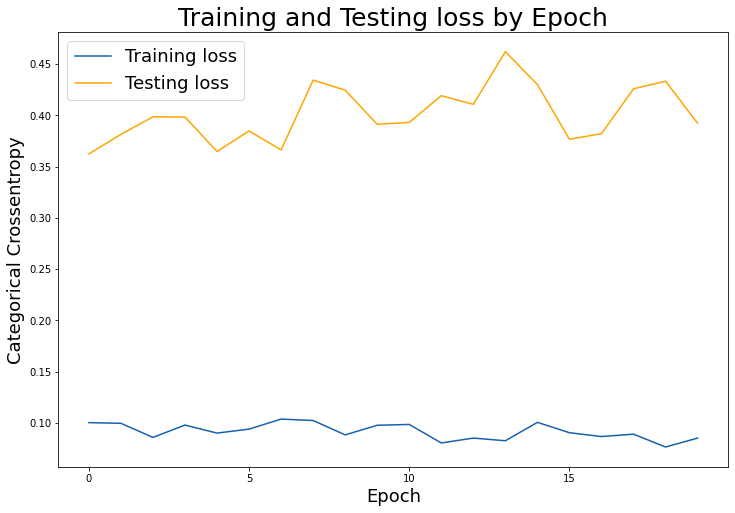

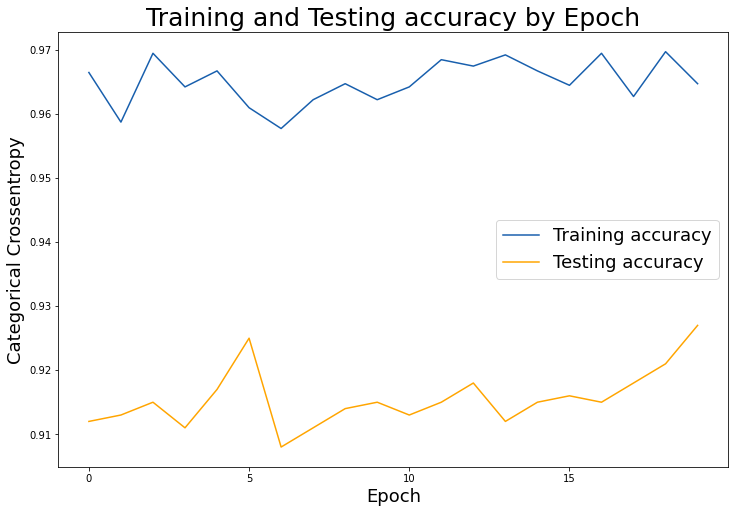

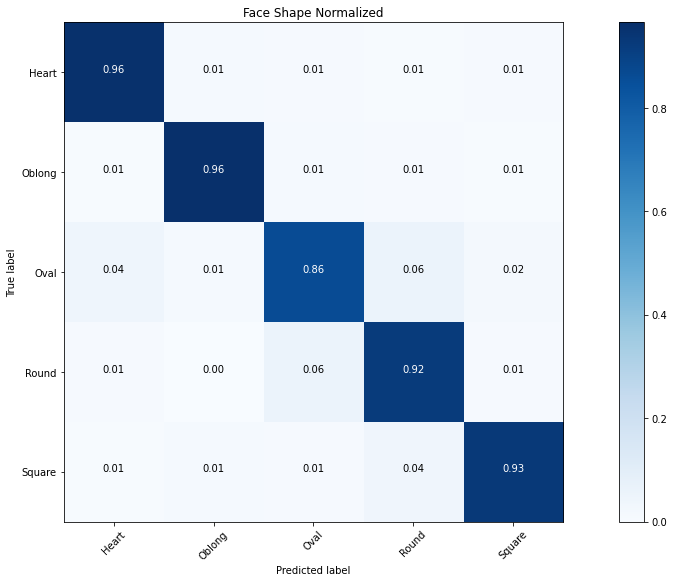

In [ ]:
plot_summary_results(model_t1, history_t2, 20)

The training accuracy is starting to stabilize, but the testing accuracy is improving (less overfit).  Let's try to run a few more epochs.

In [ ]:
history_t3 = model_t1.fit(datagen.flow(X_train, y_train, batch_size=32), 
                          steps_per_epoch=len(X_train)/32, epochs=10, 
                          validation_data=(X_test, y_test))

Epoch 1/10
125/125 [==============================] - 41s 331ms/step - loss: 0.0807 - accuracy: 0.9703 - val_loss: 0.3937 - val_accuracy: 0.9230
Epoch 2/10
125/125 [==============================] - 41s 329ms/step - loss: 0.0819 - accuracy: 0.9675 - val_loss: 0.4351 - val_accuracy: 0.9080
Epoch 3/10
125/125 [==============================] - 41s 328ms/step - loss: 0.0825 - accuracy: 0.9682 - val_loss: 0.3978 - val_accuracy: 0.9170
Epoch 4/10
125/125 [==============================] - 41s 327ms/step - loss: 0.0927 - accuracy: 0.9635 - val_loss: 0.3964 - val_accuracy: 0.9140
Epoch 5/10
125/125 [==============================] - 41s 325ms/step - loss: 0.0715 - accuracy: 0.9718 - val_loss: 0.4430 - val_accuracy: 0.9130
Epoch 6/10
125/125 [==============================] - 41s 326ms/step - loss: 0.0757 - accuracy: 0.9725 - val_loss: 0.4577 - val_accuracy: 0.9100
Epoch 7/10
125/125 [==============================] - 40s 320ms/step - loss: 0.0678 - accuracy: 0.9707 - val_loss: 0.4201 - val_ac

The validation accuracy did not improve, while the training accuracy slightly improve, hence more overfitting.  We will not run more epochs, and will evaluate the model based on the previous step.

The next notebook will evaluate the models between the one created from scratch vs. transfer learning.